In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [57]:
data = pd.read_csv('/content/drive/MyDrive/불꽃냥펀치/a.csv')

In [58]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data.columns = ['date', 'target', 'rate', 'wti1', 'brent', 'dubai', 'wti2']
data.set_index('date', inplace=True)

In [59]:
scaler_x = MinMaxScaler()
x_scale_cols = ['rate', 'wti1', 'brent', 'dubai', 'wti2']
scaled1 = scaler_x.fit_transform(data[x_scale_cols])
data_scaled1 = pd.DataFrame(scaled1)
data_scaled1.columns = x_scale_cols

scaler_y = MinMaxScaler()
y_scale_cols = ['target']
scaled2 = scaler_y.fit_transform(data[y_scale_cols])
data_scaled2 = pd.DataFrame(scaled2)
data_scaled2.columns = y_scale_cols

data_scaled = pd.merge(data_scaled1, data_scaled2, left_index=True, right_index=True)

data_scaled.set_index(data.index, inplace=True)
data_scaled.head()

,rate,wti1,brent,dubai,wti2,target
date,,,,,,
2008-01-01,0.000866,0.749465,0.611253,0.587448,0.649731,0.564679
2008-01-02,0.002204,0.749465,0.611253,0.587448,0.649731,0.564679
2008-01-03,0.001496,0.746887,0.611253,0.587448,0.649731,0.599155
2008-01-04,0.004566,0.739920,0.611253,0.587448,0.649731,0.606165
2008-01-05,0.008109,0.724450,0.611253,0.587448,0.649731,0.603668


In [60]:
TEST_SIZE = 90
WINDOW_SIZE = 60        # 과거 ?일을 기반으로 내일 데이터를 예측함

train = data_scaled[:-TEST_SIZE]
test = data_scaled[-TEST_SIZE:]

In [61]:
def make_dataset(data, label, window_size=20):      # feature_list와 label_list로 분리 작업
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [62]:
from sklearn.model_selection import train_test_split

feature_cols = ['rate', 'wti1', 'brent', 'dubai', 'wti2']             # 입력 데이터
label_cols = ['target']                               # 정답 데이터 라벨링

train_feature = train[feature_cols]
train_label = train[label_cols]

# 데이터프레임->넘파이배열
train_feature, train_label = make_dataset(train_feature, train_label, 20)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
x_train.shape, x_valid.shape

((4700, 20, 5), (1175, 20, 5))

In [63]:
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature.shape, test_label.shape

((90, 5), (90, 1))

In [64]:
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((70, 20, 5), (70, 1))

# 모델링

In [65]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16,
               input_shape=(train_feature.shape[1], train_feature.shape[2]),
               activation='relu',
               return_sequences=False)
         )

model.add(Dense(1))

In [66]:
import os

model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train,
                                    epochs=200,
                                    batch_size=16,
                                    validation_data=(x_valid, y_valid),
                                    callbacks=[early_stop, checkpoint])

Epoch 1/200
294/294 [==============================] - ETA: 0s - loss: 0.0091
Epoch 1: val_loss improved from inf to 0.00251, saving model to model/tmp_checkpoint.h5
294/294 [==============================] - 10s 28ms/step - loss: 0.0091 - val_loss: 0.0025
Epoch 2/200
  7/294 [..............................] - ETA: 6s - loss: 0.0037

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


293/294 [============================>.] - ETA: 0s - loss: 0.0026
Epoch 2: val_loss improved from 0.00251 to 0.00176, saving model to model/tmp_checkpoint.h5
294/294 [==============================] - 7s 22ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 3/200
294/294 [==============================] - ETA: 0s - loss: 0.0022
Epoch 3: val_loss did not improve from 0.00176
294/294 [==============================] - 8s 26ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 4/200
294/294 [==============================] - ETA: 0s - loss: 0.0022
Epoch 4: val_loss improved from 0.00176 to 0.00173, saving model to model/tmp_checkpoint.h5
294/294 [==============================] - 8s 26ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 5/200
293/294 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 5: val_loss improved from 0.00173 to 0.00157, saving model to model/tmp_checkpoint.h5
294/294 [==============================] - 7s 25ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 6/200
293/2

In [67]:
model.load_weights(filename)
pred = model.predict(test_feature)

pred.shape

3/3 [==============================] - 0s 6ms/step


(70, 1)

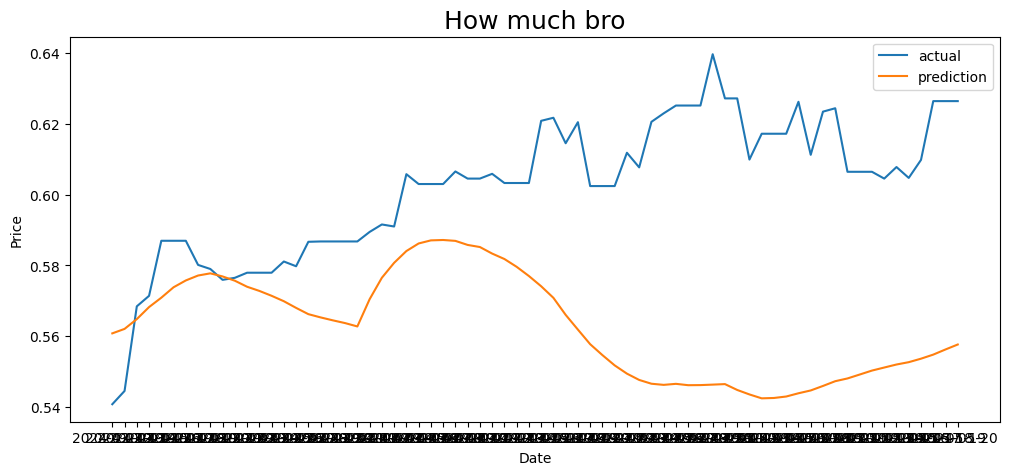

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 5))

index = data_scaled.index[-pred.shape[0]:]

plt.plot(index, test_label, label = 'actual')
plt.plot(index, pred, label = 'prediction')

plt.title('How much bro', size=18)
plt.xlabel('Date')
plt.ylabel('Price')

plt.legend()
plt.show()

In [69]:
pred_inverse = scaler_y.inverse_transform(pred)
test_label_inverse = scaler_y.inverse_transform(test_label)

In [70]:
from sklearn.metrics import mean_squared_error
MAE = mean_squared_error(test_label_inverse, pred_inverse)

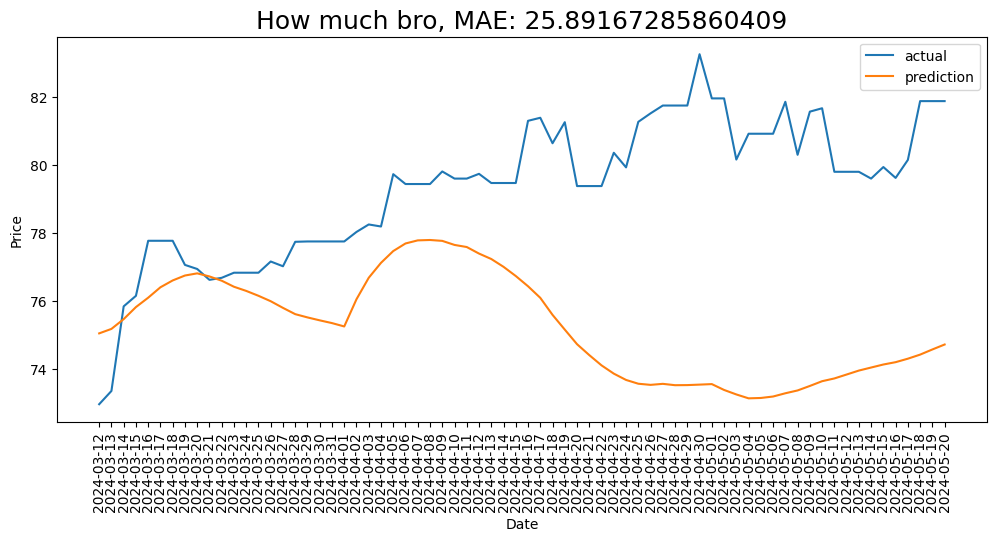

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12, 5))

index = data_scaled.index[-pred.shape[0]:]

plt.plot(index, test_label_inverse, label = 'actual')
plt.plot(index, pred_inverse, label = 'prediction')

plt.title(f'How much bro, MAE: {MAE}', size=18)
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Price')

plt.legend()
plt.show()